# Uber Trip Analysis - Future Forecasting

## Objective
Forecast short-term future demand (next 7 days) using the trained XGBoost model and recursive forecasting strategy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import timedelta

plt.style.use('ggplot')
%matplotlib inline

## 1. Load Data and Helper Functions

In [2]:
df = pd.read_csv('../data_clean/daily_aggregated_trips.csv', parse_dates=['date'], index_col='date')
df = df[['trips']] # Focus on target variable

def create_features(data):
    df_feat = data.copy()
    df_feat['day_of_week'] = df_feat.index.dayofweek
    df_feat['is_weekend'] = (df_feat.index.weekday >= 5).astype(int)
    df_feat['day_of_month'] = df_feat.index.day
    
    for lag in [1, 2, 7]:
        df_feat[f'lag_{lag}'] = df_feat['trips'].shift(lag)
    
    df_feat['rolling_mean_7'] = df_feat['trips'].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['trips'].shift(1).rolling(window=7).std()
    
    holidays = pd.to_datetime(['2015-01-01', '2015-01-19', '2015-02-14', '2015-02-16'])
    df_feat['is_holiday'] = df_feat.index.isin(holidays).astype(int)
    
    return df_feat

## 2. Train Model on Full Dataset

In [3]:
df_train_feat = create_features(df).dropna()
X_train = df_train_feat.drop(['trips'], axis=1)
y_train = df_train_feat['trips']

model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model trained.")

Model trained.


## 3. Recursive Forecasting (Next 7 Days)

In [4]:
future_days = 7
last_date = df.index.max()
current_df = df.copy()

print(f"Forecasting from {last_date}...")

for i in range(1, future_days + 1):
    next_date = last_date + timedelta(days=i)
    current_df.loc[next_date] = np.nan # Add row
    
    # Update features
    df_feat_aug = create_features(current_df)
    feat_row = df_feat_aug.loc[[next_date]].drop(['trips'], axis=1)
    
    # Predict
    pred = model.predict(feat_row)[0]
    current_df.loc[next_date, 'trips'] = pred
    print(f"{next_date.date()}: {pred:.0f} trips")

forecast_df = current_df.iloc[-future_days:]

Forecasting from 2015-02-28 00:00:00...
2015-03-01: 67385 trips
2015-03-02: 67366 trips
2015-03-03: 70134 trips
2015-03-04: 72280 trips
2015-03-05: 83006 trips
2015-03-06: 85768 trips
2015-03-07: 81783 trips


## 4. Visualize Forecast

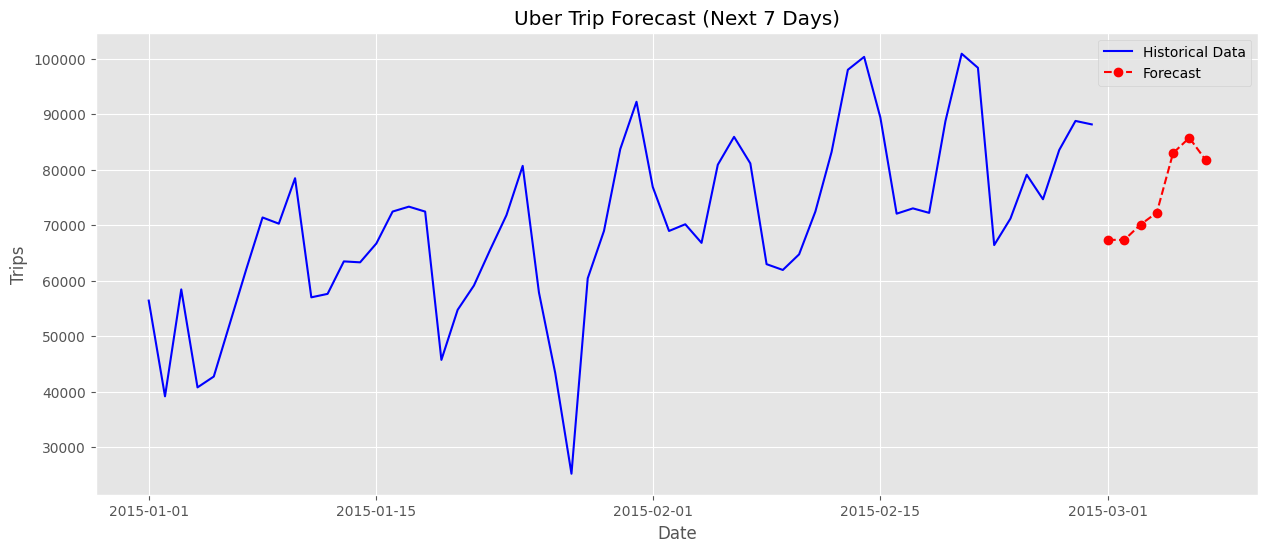

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['trips'], label='Historical Data', color='blue')
plt.plot(forecast_df.index, forecast_df['trips'], label='Forecast', color='red', linestyle='--', marker='o')
plt.title('Uber Trip Forecast (Next 7 Days)')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.legend()
plt.show()